In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import torch
from torch import nn
from torch.utils.data import DataLoader , Dataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import nltk
import re
from nltk.corpus import stopwords , words
from nltk.tokenize import word_tokenize
import string


C:\Users\saisr\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\saisr\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


### https://data.world/crawlfeeds/bloomberg-quint-news-dataset

In [2]:
df= pd.read_csv("data/bloomberg.csv")

In [3]:
df.head()

,url,title,short_description,author,date_created,date_modified,category,raw_description,description,publisher,scraped_at
0,https://www.bloombergquint.com/markets/all-you...,All You Need To Know Going Into Trade On Septe...,"Stocks in the news, big brokerage calls of the...",Darshan A Nakhwa,"23 Sep 2021, 7:05 AM IST","23 Sep 2021, 7:05 AM IST",Markets,"<div class=""story-element story-element-text"">...",Asian stocks were steady early Thursday after ...,https://www.bloombergquint.com/,2021-09-24T00:01:25
1,https://www.bloombergquint.com/business/bridge...,"Bridgestone CEO Backs Safe Tokyo Olympics, Dia...","Bridgestone CEO Backs Safe Tokyo Olympics, Dia...",Shiho Takezawa &,"23 Apr 2021, 5:35 AM IST","23 Apr 2021, 6:35 AM IST",Business,"<div class=""story-element story-element-text"">...",Bridgestone Corp. will support the Tokyo Olym...,https://www.bloombergquint.com/,2021-09-24T00:01:26
2,https://www.bloombergquint.com/markets/stocks-...,"Stocks To Watch: HCL Tech, Cyient, M&M Financi...",Here are the stocks to watch in trade today...,BQ Desk,"23 Apr 2021, 7:29 AM IST","23 Apr 2021, 7:29 AM IST",Markets,"<div class=""story-element story-element-text"">...",Indian equity benchmarks reversed losses made ...,https://www.bloombergquint.com/,2021-09-24T00:01:26
3,https://www.bloombergquint.com/research-report...,Localised Lockdowns Cannot But Impinge On Econ...,Localised Lockdowns Cannot But Impinge On Econ...,Nirmal Bang Institutional Research,"26 Apr 2021, 7:58 AM IST","26 Apr 2021, 7:58 AM IST",Research Reports,"<div class=""story-element story-element-text"">...","Nirmal Bang Report, We assess the ‘state of af...",https://www.bloombergquint.com/,2021-09-24T00:01:26
4,https://www.bloombergquint.com/business/cp-rai...,CP Rail Wins Regulator Exemption From Tougher ...,CP Rail Wins Regulator Exemption From Tougher ...,Thomas Black,"24 Apr 2021, 7:08 AM IST","24 Apr 2021, 7:44 AM IST",Business,"<div class=""story-element story-element-text"">...",Canadian Pacific Railway Ltd. won a petition ...,https://www.bloombergquint.com/,2021-09-24T00:01:27


In [4]:
df.columns

Index(['url', 'title', 'short_description', 'author', 'date_created',
       'date_modified', 'category', 'raw_description', 'description',
       'publisher', 'scraped_at'],
      dtype='object')

In [5]:
df.shape

(7018, 11)

In [6]:
df["category"].value_counts() >50 

category
Videos                          True
Business                        True
OnWeb                           True
Politics                        True
Markets                         True
Research Reports                True
Global Economics                True
Opinion/Gadfly                  True
Technology                      True
Coronavirus Outbreak            True
China                           True
Videos/In The News              True
Businessweek                   False
Pursuits                       False
Opinion                        False
Law-and-Policy                 False
QuickTakes                     False
Markets/Quarterly Earnings     False
Economy & Finance              False
BQ Blue Exclusive              False
Opinion/View                   False
Crypto                         False
GST                            False
Wealth                         False
IPOs                           False
Mutual Funds                   False
CityLab                      

In [7]:
df["category"].value_counts()[df["category"].value_counts() > 50].index

Index(['Videos', 'Business', 'OnWeb', 'Politics', 'Markets',
       'Research Reports', 'Global Economics', 'Opinion/Gadfly', 'Technology',
       'Coronavirus Outbreak', 'China', 'Videos/In The News'],
      dtype='object', name='category')

In [8]:
df.shape

(7018, 11)

In [9]:
df.isnull().sum()

url                     0
title                   0
short_description       0
author               2912
date_created         2912
date_modified        2912
category                0
raw_description        22
description          2912
publisher               0
scraped_at              0
dtype: int64

In [10]:
df=df.dropna(subset=["category","short_description","description"])

In [11]:
df[df["category"].isin(df["category"].value_counts()[df["category"].value_counts() > 50].index)].shape

(3901, 11)

In [12]:
#Filtering out categories with their frequency greater than 50

In [13]:
df2=df[df["category"].isin(df["category"].value_counts()[df["category"].value_counts() > 50].index)]

In [14]:
df2.shape

(3901, 11)

In [15]:
df2.head()

,url,title,short_description,author,date_created,date_modified,category,raw_description,description,publisher,scraped_at
0,https://www.bloombergquint.com/markets/all-you...,All You Need To Know Going Into Trade On Septe...,"Stocks in the news, big brokerage calls of the...",Darshan A Nakhwa,"23 Sep 2021, 7:05 AM IST","23 Sep 2021, 7:05 AM IST",Markets,"<div class=""story-element story-element-text"">...",Asian stocks were steady early Thursday after ...,https://www.bloombergquint.com/,2021-09-24T00:01:25
1,https://www.bloombergquint.com/business/bridge...,"Bridgestone CEO Backs Safe Tokyo Olympics, Dia...","Bridgestone CEO Backs Safe Tokyo Olympics, Dia...",Shiho Takezawa &,"23 Apr 2021, 5:35 AM IST","23 Apr 2021, 6:35 AM IST",Business,"<div class=""story-element story-element-text"">...",Bridgestone Corp. will support the Tokyo Olym...,https://www.bloombergquint.com/,2021-09-24T00:01:26
2,https://www.bloombergquint.com/markets/stocks-...,"Stocks To Watch: HCL Tech, Cyient, M&M Financi...",Here are the stocks to watch in trade today...,BQ Desk,"23 Apr 2021, 7:29 AM IST","23 Apr 2021, 7:29 AM IST",Markets,"<div class=""story-element story-element-text"">...",Indian equity benchmarks reversed losses made ...,https://www.bloombergquint.com/,2021-09-24T00:01:26
3,https://www.bloombergquint.com/research-report...,Localised Lockdowns Cannot But Impinge On Econ...,Localised Lockdowns Cannot But Impinge On Econ...,Nirmal Bang Institutional Research,"26 Apr 2021, 7:58 AM IST","26 Apr 2021, 7:58 AM IST",Research Reports,"<div class=""story-element story-element-text"">...","Nirmal Bang Report, We assess the ‘state of af...",https://www.bloombergquint.com/,2021-09-24T00:01:26
4,https://www.bloombergquint.com/business/cp-rai...,CP Rail Wins Regulator Exemption From Tougher ...,CP Rail Wins Regulator Exemption From Tougher ...,Thomas Black,"24 Apr 2021, 7:08 AM IST","24 Apr 2021, 7:44 AM IST",Business,"<div class=""story-element story-element-text"">...",Canadian Pacific Railway Ltd. won a petition ...,https://www.bloombergquint.com/,2021-09-24T00:01:27


## Two different Topic modelling tasks using description and short description of data for training of models and analyse their performance

In [16]:
df2=df2[["short_description","description","category"]]

In [17]:
df3=df2[["description","category"]]

In [18]:
df3

,description,category
0,Asian stocks were steady early Thursday after ...,Markets
1,Bridgestone Corp. will support the Tokyo Olym...,Business
2,Indian equity benchmarks reversed losses made ...,Markets
3,"Nirmal Bang Report, We assess the ‘state of af...",Research Reports
4,Canadian Pacific Railway Ltd. won a petition ...,Business
...,...,...
5456,The ‘mother of all deals’ seems to be coming ...,Technology
5550,"Sushma Swaraj – , – did the ultimate throwbac...",Politics
5580,"A beheading in France, a gun-battle at a touri...",Politics
6513,It was an autumn afternoon in 2007 when I step...,Politics


In [19]:
df3["description"].apply(len)

0       6589
1       1484
2        300
3        755
4       1754
        ... 
5456    1605
5550    1842
5580    3330
6513    5227
6660     921
Name: description, Length: 3901, dtype: int64

In [20]:
stopwords = set(stopwords.words("english"))

In [21]:
def preprocess(sentence,stopwords):
    
    sentence=sentence.lower()    
    tokens=word_tokenize(sentence)
    tokens_no_stopwords = [token for token in tokens if token not in stopwords  ]
    return " ".join(tokens_no_stopwords)

In [22]:
df3["description"]=df3["description"].apply(preprocess,args=[stopwords])

C:\Users\saisr\AppData\Local\Temp/ipykernel_25868/705922551.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["description"]=df3["description"].apply(preprocess,args=[stopwords])


In [23]:
df3["description"].apply(len)

0       5758
1       1177
2        236
3        589
4       1344
        ... 
5456    1149
5550    1355
5580    2453
6513    3761
6660     677
Name: description, Length: 3901, dtype: int64

In [24]:
df3.head()

,description,category
0,asian stocks steady early thursday u.s. shares...,Markets
1,bridgestone corp. support tokyo olympics paral...,Business
2,indian equity benchmarks reversed losses made ...,Markets
3,"nirmal bang report , assess ‘ state affairs ’ ...",Research Reports
4,canadian pacific railway ltd. petition propose...,Business


In [25]:
words=[sentences.split() for sentences in df3["description"]]

In [26]:
words=[word for sentence in words for word in sentence]

In [27]:
len(words)

1345549

In [28]:
unique_words=sorted(list(set(words)))

In [29]:
len(unique_words)

58097

In [30]:
len(unique_words)

58097

In [31]:
unique_words

['!',
 '#',
 '$',
 '%',
 '&',
 "'",
 "''",
 "'buy",
 "'continuing",
 "'d",
 "'doodh",
 "'em",
 "'held",
 "'hold",
 "'holds",
 "'kalakand",
 "'ll",
 "'m",
 "'myko",
 "'profitability",
 "'re",
 "'s",
 "'self-employed",
 "'sell",
 "'sells",
 "'ve",
 "'win",
 '(',
 ')',
 '*',
 '+',
 '++++++++++++++++++++',
 '+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++',
 '+/-2.8',
 ',',
 '-',
 '--',
 '-0.4',
 '-0.5',
 '-0.65',
 '-0.75',
 '-10',
 '-10.2',
 '-12',
 '-13',
 '-15',
 '-18.3',
 '-19',
 '-1x',
 '-2',
 '-20',
 '-21',
 '-24',
 '-26',
 '-3',
 '-3.5',
 '-30',
 '-4',
 '-4.2',
 '-4.85',
 '-45',
 '-46',
 '-5',
 '-5.1',
 '-5.2',
 '-5.3',
 '-5.4',
 '-5.8',
 '-50',
 '-50°',
 '-52',
 '-6',
 '-6.0',
 '-6.1',
 '-6.3',
 '-6.5',
 '-60',
 '-7',
 '-7.5',
 '-7.8',
 '-70°',
 '-9',
 '-based',
 '-care',
 '-class',
 '-conquering-wall',
 '-date',
 '-david',
 '-emblazoned',
 '-flung',
 '-funded',
 '-good',
 '-ing',
 '-led',
 '-lending',
 '-like',
 '-linked',
 '-maeva',
 '-mexico-canada',
 '-move'

In [32]:
def check(word):
    for i in word:
        if(i.isdigit() or i in string.punctuation):
            return False
    return True

In [33]:
check("hi0")

False

In [34]:
unique_words = [word for word in unique_words if check(word)]

In [35]:
len(unique_words)

37945

In [36]:
unique_words

['aa',
 'aaa',
 'aac',
 'aalto',
 'aalund',
 'aandahl',
 'aapi',
 'aarey',
 'aaron',
 'aarp',
 'aarup',
 'aavas',
 'aayog',
 'aayush',
 'ab',
 'aba',
 'aback',
 'abakkus',
 'abala',
 'abalone',
 'abandon',
 'abandoned',
 'abandoning',
 'abandons',
 'abandon—to',
 'abascal',
 'abasolo',
 'abassi',
 'abate',
 'abated',
 'abates',
 'abating',
 'abax',
 'abb',
 'abba',
 'abbas',
 'abbassian',
 'abbett',
 'abbott',
 'abbreviated',
 'abbreviation',
 'abbvie',
 'abby',
 'abc',
 'abdalla',
 'abdallah',
 'abdel',
 'abdelkerim',
 'abdi',
 'abdicating',
 'abdirahman',
 'abdirizak',
 'abdo',
 'abdolreza',
 'abdoulaye',
 'abduct',
 'abducted',
 'abductees',
 'abduction',
 'abductions',
 'abdul',
 'abdulaziz',
 'abdulkarim',
 'abdulla',
 'abdullah',
 'abdullahi',
 'abdulmajeed',
 'abe',
 'abecassis',
 'abeer',
 'abel',
 'abenomics',
 'aberdeen',
 'aberration',
 'abet',
 'abetting',
 'abey',
 'abhijit',
 'abhishek',
 'abhorrent',
 'abide',
 'abides',
 'abidine',
 'abidjan',
 'abigail',
 'ability',
 '

In [37]:
#eng_words= set(words.words())

In [38]:
#len(eng_words)

In [39]:
#unique_words= [word for word in unique_words if word in eng_words]

In [40]:
vocab = {word:int(i) for i,word in enumerate(unique_words)}

In [41]:
len(vocab)

37945

In [42]:
vocab["unknown"]

35432

In [43]:
df3.head()

,description,category
0,asian stocks steady early thursday u.s. shares...,Markets
1,bridgestone corp. support tokyo olympics paral...,Business
2,indian equity benchmarks reversed losses made ...,Markets
3,"nirmal bang report , assess ‘ state affairs ’ ...",Research Reports
4,canadian pacific railway ltd. petition propose...,Business


In [44]:
vocab["unknown"]

35432

In [45]:
vocab

{'aa': 0,
 'aaa': 1,
 'aac': 2,
 'aalto': 3,
 'aalund': 4,
 'aandahl': 5,
 'aapi': 6,
 'aarey': 7,
 'aaron': 8,
 'aarp': 9,
 'aarup': 10,
 'aavas': 11,
 'aayog': 12,
 'aayush': 13,
 'ab': 14,
 'aba': 15,
 'aback': 16,
 'abakkus': 17,
 'abala': 18,
 'abalone': 19,
 'abandon': 20,
 'abandoned': 21,
 'abandoning': 22,
 'abandons': 23,
 'abandon—to': 24,
 'abascal': 25,
 'abasolo': 26,
 'abassi': 27,
 'abate': 28,
 'abated': 29,
 'abates': 30,
 'abating': 31,
 'abax': 32,
 'abb': 33,
 'abba': 34,
 'abbas': 35,
 'abbassian': 36,
 'abbett': 37,
 'abbott': 38,
 'abbreviated': 39,
 'abbreviation': 40,
 'abbvie': 41,
 'abby': 42,
 'abc': 43,
 'abdalla': 44,
 'abdallah': 45,
 'abdel': 46,
 'abdelkerim': 47,
 'abdi': 48,
 'abdicating': 49,
 'abdirahman': 50,
 'abdirizak': 51,
 'abdo': 52,
 'abdolreza': 53,
 'abdoulaye': 54,
 'abduct': 55,
 'abducted': 56,
 'abductees': 57,
 'abduction': 58,
 'abductions': 59,
 'abdul': 60,
 'abdulaziz': 61,
 'abdulkarim': 62,
 'abdulla': 63,
 'abdullah': 64,
 'ab

In [46]:
def sentence_to_id(sentence,vocab):
    return [vocab["unknown"] if word not in vocab else vocab[word] for word in sentence]

In [47]:
len(df3)

3901

In [48]:
df3["description"]=df3["description"].apply(sentence_to_id,args=[vocab])

C:\Users\saisr\AppData\Local\Temp/ipykernel_25868/3639638895.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["description"]=df3["description"].apply(sentence_to_id,args=[vocab])


In [49]:
df3.head()

,description,category
0,"[35432, 35432, 35432, 35432, 22194, 35432, 354...",Markets
1,"[2496, 26792, 35432, 35432, 13346, 10348, 3543...",Business
2,"[35432, 22194, 35432, 35432, 35432, 22194, 354...",Markets
3,"[22194, 35432, 26792, 35432, 35432, 18635, 354...",Research Reports
4,"[4712, 35432, 22194, 35432, 35432, 35432, 3543...",Business


In [50]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3901 entries, 0 to 6660
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  3901 non-null   object
 1   category     3901 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [51]:
tag_ids = {tag:i for i,tag in enumerate(sorted(df3["category"].unique()))}

In [52]:
tag_ids

{'Business': 0,
 'China': 1,
 'Coronavirus Outbreak': 2,
 'Global Economics': 3,
 'Markets': 4,
 'OnWeb': 5,
 'Opinion/Gadfly': 6,
 'Politics': 7,
 'Research Reports': 8,
 'Technology': 9}

In [53]:
def tag_to_id(tag,tag_ids):
    return tag_ids[tag]

In [54]:
df3["category"]=df3["category"].apply(tag_to_id,args=[tag_ids])

C:\Users\saisr\AppData\Local\Temp/ipykernel_25868/3577534169.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["category"]=df3["category"].apply(tag_to_id,args=[tag_ids])


In [55]:
df3.head()

,description,category
0,"[35432, 35432, 35432, 35432, 22194, 35432, 354...",4
1,"[2496, 26792, 35432, 35432, 13346, 10348, 3543...",0
2,"[35432, 22194, 35432, 35432, 35432, 22194, 354...",4
3,"[22194, 35432, 26792, 35432, 35432, 18635, 354...",8
4,"[4712, 35432, 22194, 35432, 35432, 35432, 3543...",0


In [56]:
df3.shape

(3901, 2)

In [57]:
df3["category"]

0       4
1       0
2       4
3       8
4       0
       ..
5456    9
5550    7
5580    7
6513    7
6660    9
Name: category, Length: 3901, dtype: int64

In [58]:
df3.head()

,description,category
0,"[35432, 35432, 35432, 35432, 22194, 35432, 354...",4
1,"[2496, 26792, 35432, 35432, 13346, 10348, 3543...",0
2,"[35432, 22194, 35432, 35432, 35432, 22194, 354...",4
3,"[22194, 35432, 26792, 35432, 35432, 18635, 354...",8
4,"[4712, 35432, 22194, 35432, 35432, 35432, 3543...",0


In [59]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3901 entries, 0 to 6660
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  3901 non-null   object
 1   category     3901 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 91.4+ KB


In [60]:
df3.reset_index(drop=True,inplace=True)

In [61]:
x_train_val , x_test , y_train_val , y_test =train_test_split(df3["description"],df3["category"],test_size=0.1)

In [62]:
x_train_val.shape , x_test.shape , y_train_val.shape , y_test.shape

((3510,), (391,), (3510,), (391,))

In [63]:
x_train , x_val , y_train , y_val =train_test_split(x_train_val,y_train_val,test_size=0.111231)

In [64]:
x_train.shape , x_val.shape , y_train.shape , y_val.shape

((3119,), (391,), (3119,), (391,))

In [65]:
x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

### without hyperparameter tuning using long description 

In [66]:
class tensor_data(Dataset):
    def __init__(self,sentences,tags):
        super().__init__()
        self.sentences= sentences
        self.tags=tags
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, id_):
        return torch.tensor(self.sentences.iloc[id_], dtype=torch.long), torch.tensor(self.tags.iloc[id_], dtype=torch.long)

In [67]:
df_tensor=tensor_data(x_train,y_train)

In [68]:
def custom_collate_fn(batch):
    sequences, labels = zip(*batch)
    
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
    sequence_lengths = torch.tensor([len(seq) for seq in sequences], dtype=torch.long)
    max_length = padded_sequences.size(1)
    
    #mask = torch.arange(max_length).expand(len(sequences), max_length) < sequence_lengths.unsqueeze(1)
    
    labels=torch.tensor(labels,dtype=torch.long)
    
    return padded_sequences,labels#, mask

In [69]:
train_dataloader = DataLoader(df_tensor,batch_size=16,shuffle=True,collate_fn=custom_collate_fn)

In [70]:
class Encoder(nn.Module):
    def __init__(self,vocab_size_en,embedding_size_en,hidden_size_en,latent_size_en):
        super().__init__()
        self.embedding=nn.Embedding(vocab_size_en,embedding_size_en)
        self.lstm=nn.LSTM(embedding_size_en,hidden_size_en, batch_first=True)
        self.fc=nn.Linear(hidden_size_en,latent_size_en)
        
    def forward(self,x):
        y=self.embedding(x)
        out , (hidden , c)=self.lstm(y)
        latent = self.fc(hidden[-1])
        
        return latent

In [71]:
class Decoder(nn.Module):
    
    def __init__(self,latent_size_en,hidden_size_de,latent_size_de,output_size):
        
        super().__init__()
        self.fc=nn.Linear(latent_size_en,hidden_size_de)
        self.lstm=nn.LSTM(hidden_size_de,latent_size_de, batch_first=True)
        self.final=nn.Linear(latent_size_de , output_size)
                
    def forward(self,x):
        y=self.fc(x).unsqueeze(1) 
        out , (hidden , c)=self.lstm(y)
        output = self.final(hidden[-1].squeeze(1))
        return output

In [72]:
class combined(nn.Module):
    
    def __init__(self,vocab_size_en,embedding_size_en,hidden_size_en,latent_size_en,hidden_size_de,latent_size_de,output_size):
        super().__init__()
        
        self.encoder = Encoder(vocab_size_en,embedding_size_en,hidden_size_en,latent_size_en)
        self.decoder = Decoder(latent_size_en,hidden_size_de,latent_size_de,output_size)
        
    def forward(self,x):
        
        latent= self.encoder(x)
        y= self.decoder(latent)
        
        return y
        

In [73]:
vocab_size_en = len(vocab)
embedding_size_en = 256
hidden_size_en = 512
latent_size_en = 512
hidden_size_de = 512
latent_size_de = 256
output_size = df3['category'].nunique()

In [74]:
model = combined(vocab_size_en,embedding_size_en,hidden_size_en,latent_size_en,hidden_size_de,latent_size_de,output_size)

In [75]:
for i,j in model.named_parameters():
    print(i," ",j.shape)

encoder.embedding.weight   torch.Size([37945, 256])
encoder.lstm.weight_ih_l0   torch.Size([2048, 256])
encoder.lstm.weight_hh_l0   torch.Size([2048, 512])
encoder.lstm.bias_ih_l0   torch.Size([2048])
encoder.lstm.bias_hh_l0   torch.Size([2048])
encoder.fc.weight   torch.Size([512, 512])
encoder.fc.bias   torch.Size([512])
decoder.fc.weight   torch.Size([512, 512])
decoder.fc.bias   torch.Size([512])
decoder.lstm.weight_ih_l0   torch.Size([1024, 512])
decoder.lstm.weight_hh_l0   torch.Size([1024, 256])
decoder.lstm.bias_ih_l0   torch.Size([1024])
decoder.lstm.bias_hh_l0   torch.Size([1024])
decoder.final.weight   torch.Size([10, 256])
decoder.final.bias   torch.Size([10])


In [76]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.1)

In [77]:
loss_epochs=[]
for epoch in range(2):
    
    print("Epoch --- >",epoch)
    
    model.train()
    
    avg_loss=avg_eval_loss=0
    
    for i,batch in enumerate(train_dataloader):
        x,y = batch
        y_pred = model(x)
        
        y_pred = y_pred.view(-1, output_size)
        y = y.view(-1)
        
        #print(y_pred.shape,y.shape)
        
        loss=loss_fn(y_pred,y)
        
        if i%10 == 9 :
            print("Loss for batch ",i+1," is ",loss.item())
            
        avg_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print("avg_loss after training",avg_loss/(i+1))  
    
    loss_epochs.append(avg_loss/(i+1))

Epoch --- > 0
Loss for batch  10  is  13.30806827545166
Loss for batch  20  is  7.140284061431885
Loss for batch  30  is  10.8002290725708
Loss for batch  40  is  3.370833396911621
Loss for batch  50  is  3.0372695922851562
Loss for batch  60  is  4.568886756896973
Loss for batch  70  is  3.0107340812683105
Loss for batch  80  is  2.0296669006347656
Loss for batch  90  is  2.7179272174835205
Loss for batch  100  is  2.0742366313934326
Loss for batch  110  is  2.3889880180358887
Loss for batch  120  is  2.29058837890625
Loss for batch  130  is  2.370352029800415
Loss for batch  140  is  4.007831573486328
Loss for batch  150  is  2.087127208709717
Loss for batch  160  is  3.0018093585968018
Loss for batch  170  is  2.863699436187744
Loss for batch  180  is  3.4653584957122803
Loss for batch  190  is  3.7940409183502197
avg_loss after training 3.9551918329336706
Epoch --- > 1
Loss for batch  10  is  2.924651861190796
Loss for batch  20  is  2.409412384033203
Loss for batch  30  is  5.6819

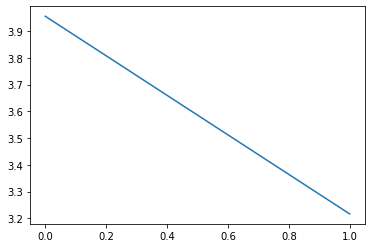

In [78]:
plt.plot(loss_epochs)

In [79]:
df_test_tensor=tensor_data(x_test,y_test)

In [80]:
test_dataloader = DataLoader(df_test_tensor,batch_size=16,shuffle=True,collate_fn=custom_collate_fn)

In [81]:
acc=[]

for i,data in enumerate(test_dataloader):
    x,y = data
    
    model.eval()

    with torch.no_grad():
        y_pred = model(x)
        print(y_pred.shape)
        _, final_pred = torch.max(y_pred, dim=1)
        
    temp = accuracy_score(y,final_pred)
        
    acc.append(temp)
        
    print("Accuracy for ",i,"th batch in test set is ",temp)
    

torch.Size([16, 10])
Accuracy for  0 th batch in test set is  0.0
torch.Size([16, 10])
Accuracy for  1 th batch in test set is  0.0
torch.Size([16, 10])
Accuracy for  2 th batch in test set is  0.0
torch.Size([16, 10])
Accuracy for  3 th batch in test set is  0.0
torch.Size([16, 10])
Accuracy for  4 th batch in test set is  0.0
torch.Size([16, 10])
Accuracy for  5 th batch in test set is  0.0625
torch.Size([16, 10])
Accuracy for  6 th batch in test set is  0.0
torch.Size([16, 10])
Accuracy for  7 th batch in test set is  0.0
torch.Size([16, 10])
Accuracy for  8 th batch in test set is  0.0
torch.Size([16, 10])
Accuracy for  9 th batch in test set is  0.0
torch.Size([16, 10])
Accuracy for  10 th batch in test set is  0.0
torch.Size([16, 10])
Accuracy for  11 th batch in test set is  0.0625
torch.Size([16, 10])
Accuracy for  12 th batch in test set is  0.125
torch.Size([16, 10])
Accuracy for  13 th batch in test set is  0.125
torch.Size([16, 10])
Accuracy for  14 th batch in test set is 

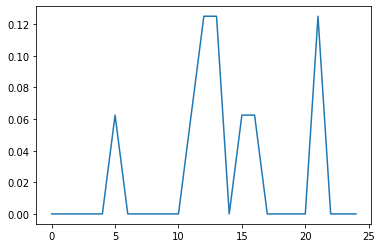

In [82]:
plt.plot(acc)
plt.show()

### with hyperparameter tuning 

### without hyper parameter tuning using short description

In [83]:
df4 = df2[["short_description","category"]]

In [84]:
df4.head()

,short_description,category
0,"Stocks in the news, big brokerage calls of the...",Markets
1,"Bridgestone CEO Backs Safe Tokyo Olympics, Dia...",Business
2,Here are the stocks to watch in trade today...,Markets
3,Localised Lockdowns Cannot But Impinge On Econ...,Research Reports
4,CP Rail Wins Regulator Exemption From Tougher ...,Business


In [85]:
df4["short_description"]=df4["short_description"].apply(preprocess,args=[stopwords])
df4["short_description"]=df4["short_description"].apply(sentence_to_id,args=[vocab])
df4.head()

C:\Users\saisr\AppData\Local\Temp/ipykernel_25868/3079926141.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4["short_description"]=df4["short_description"].apply(preprocess,args=[stopwords])
C:\Users\saisr\AppData\Local\Temp/ipykernel_25868/3079926141.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4["short_description"]=df4["short_description"].apply(sentence_to_id,args=[vocab])


,short_description,category
0,"[35432, 35432, 35432, 4712, 17867, 35432, 3543...",Markets
1,"[2496, 26792, 35432, 35432, 13346, 10348, 3543...",Business
2,"[35432, 35432, 35432, 4712, 17867, 35432, 3543...",Markets
3,"[18635, 35432, 4712, 35432, 18635, 35432, 3543...",Research Reports
4,"[4712, 24083, 35432, 26792, 35432, 35432, 1863...",Business


In [86]:
df4["category"]=df4["category"].apply(tag_to_id,args=[tag_ids])
df4.head()

C:\Users\saisr\AppData\Local\Temp/ipykernel_25868/2689645286.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4["category"]=df4["category"].apply(tag_to_id,args=[tag_ids])


,short_description,category
0,"[35432, 35432, 35432, 4712, 17867, 35432, 3543...",4
1,"[2496, 26792, 35432, 35432, 13346, 10348, 3543...",0
2,"[35432, 35432, 35432, 4712, 17867, 35432, 3543...",4
3,"[18635, 35432, 4712, 35432, 18635, 35432, 3543...",8
4,"[4712, 24083, 35432, 26792, 35432, 35432, 1863...",0


In [87]:
df4.reset_index(drop=True,inplace=True)

In [88]:
x_train_val , x_test , y_train_val , y_test =train_test_split(df4["short_description"],df4["category"],test_size=0.1)
x_train , x_val , y_train , y_val =train_test_split(x_train_val,y_train_val,test_size=0.111231)
x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

In [89]:
df_tensor=tensor_data(x_train,y_train)
train_dataloader = DataLoader(df_tensor,batch_size=16,shuffle=True,collate_fn=custom_collate_fn)


In [90]:
model = combined(vocab_size_en,embedding_size_en,hidden_size_en,latent_size_en,hidden_size_de,latent_size_de,output_size)


In [91]:
for i,j in model.named_parameters():
    print(i," ",j.shape)

encoder.embedding.weight   torch.Size([37945, 256])
encoder.lstm.weight_ih_l0   torch.Size([2048, 256])
encoder.lstm.weight_hh_l0   torch.Size([2048, 512])
encoder.lstm.bias_ih_l0   torch.Size([2048])
encoder.lstm.bias_hh_l0   torch.Size([2048])
encoder.fc.weight   torch.Size([512, 512])
encoder.fc.bias   torch.Size([512])
decoder.fc.weight   torch.Size([512, 512])
decoder.fc.bias   torch.Size([512])
decoder.lstm.weight_ih_l0   torch.Size([1024, 512])
decoder.lstm.weight_hh_l0   torch.Size([1024, 256])
decoder.lstm.bias_ih_l0   torch.Size([1024])
decoder.lstm.bias_hh_l0   torch.Size([1024])
decoder.final.weight   torch.Size([10, 256])
decoder.final.bias   torch.Size([10])


In [92]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.1)

In [93]:
loss_epochs=[]
for epoch in range(2):
    
    print("Epoch --- >",epoch)
    
    model.train()
    
    avg_loss=avg_eval_loss=0
    
    for i,batch in enumerate(train_dataloader):
        x,y = batch
        y_pred = model(x)
        
        y_pred = y_pred.view(-1, output_size)
        y = y.view(-1)
        
        #print(y_pred.shape,y.shape)
        
        loss=loss_fn(y_pred,y)
        
        if i%10 == 9 :
            print("Loss for batch ",i+1," is ",loss.item())
            
        avg_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print("avg_loss after training",avg_loss/(i+1))  
    
    loss_epochs.append(avg_loss/(i+1))

Epoch --- > 0
Loss for batch  10  is  10.410268783569336
Loss for batch  20  is  5.42256498336792
Loss for batch  30  is  3.742841958999634
Loss for batch  40  is  4.629308223724365
Loss for batch  50  is  4.065304279327393
Loss for batch  60  is  2.7742323875427246
Loss for batch  70  is  2.6446683406829834
Loss for batch  80  is  3.143334150314331
Loss for batch  90  is  3.087667942047119
Loss for batch  100  is  3.094482183456421
Loss for batch  110  is  2.2906484603881836
Loss for batch  120  is  3.5150527954101562
Loss for batch  130  is  3.6124660968780518
Loss for batch  140  is  3.1345107555389404
Loss for batch  150  is  4.726995944976807
Loss for batch  160  is  5.647018909454346
Loss for batch  170  is  2.52888822555542
Loss for batch  180  is  4.307801246643066
Loss for batch  190  is  4.3405632972717285
avg_loss after training 3.729287376159277
Epoch --- > 1
Loss for batch  10  is  2.611027717590332
Loss for batch  20  is  4.112354278564453
Loss for batch  30  is  3.163573

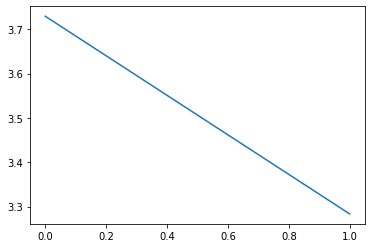

In [94]:
plt.plot(loss_epochs)
plt.show()

In [95]:
df_test_tensor=tensor_data(x_test,y_test)
test_dataloader = DataLoader(df_test_tensor,batch_size=16,shuffle=True,collate_fn=custom_collate_fn)
acc=[]
for i,data in enumerate(test_dataloader):
    x,y = data
    
    model.eval()

    with torch.no_grad():
        y_pred = model(x)
        print(y_pred.shape)
        _, final_pred = torch.max(y_pred, dim=1)
        
    temp = accuracy_score(y,final_pred)
        
    acc.append(temp)
        
    print("Accuracy for ",i,"th batch in test set is ",temp)


torch.Size([16, 10])
Accuracy for  0 th batch in test set is  0.25
torch.Size([16, 10])
Accuracy for  1 th batch in test set is  0.3125
torch.Size([16, 10])
Accuracy for  2 th batch in test set is  0.25
torch.Size([16, 10])
Accuracy for  3 th batch in test set is  0.25
torch.Size([16, 10])
Accuracy for  4 th batch in test set is  0.3125
torch.Size([16, 10])
Accuracy for  5 th batch in test set is  0.3125
torch.Size([16, 10])
Accuracy for  6 th batch in test set is  0.375
torch.Size([16, 10])
Accuracy for  7 th batch in test set is  0.125
torch.Size([16, 10])
Accuracy for  8 th batch in test set is  0.125
torch.Size([16, 10])
Accuracy for  9 th batch in test set is  0.0625
torch.Size([16, 10])
Accuracy for  10 th batch in test set is  0.3125
torch.Size([16, 10])
Accuracy for  11 th batch in test set is  0.3125
torch.Size([16, 10])
Accuracy for  12 th batch in test set is  0.3125
torch.Size([16, 10])
Accuracy for  13 th batch in test set is  0.4375
torch.Size([16, 10])
Accuracy for  14 t

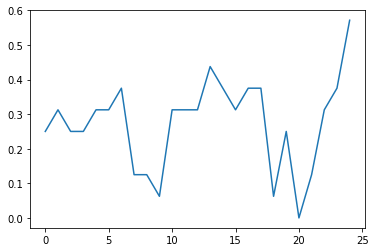

In [96]:
plt.plot(acc)
plt.show()